In [1]:
pip install mxnet

     |████████████████████████████████| 47.3 MB 1.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [3]:
pip install d2l

     |████████████████████████████████| 82 kB 609 kB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 9.9 MB 36.2 MB/s 
     |████████████████████████████████| 61 kB 7.6 MB/s 
     |████████████████████████████████| 11.6 MB 36.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the p

In [1]:
%matplotlib inline
import math
import time
from mxnet import np
from d2l import mxnet as d2l

In [2]:
n = 10000
a = np.ones(n)
b = np.ones(n)

In [4]:
class Timer: 
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [5]:
c = np.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'4.51414 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00038 sec'

In [7]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

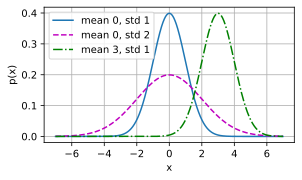

In [8]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Linear Regression Implementation from Scratch

In [9]:
%matplotlib inline
import random
from mxnet import autograd, np, npx
from d2l import mxnet as d2l

npx.set_np()

In [10]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [11]:
print('features:', features[0],'\nlabel:', labels[0])

features: [2.2122064 1.1630787] 
label: [4.662078]


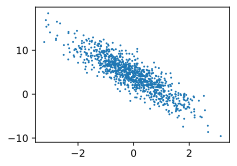

In [12]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].asnumpy(), labels.asnumpy(), 1);

In [13]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [14]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

[[ 0.5477517   0.15074243]
 [-0.4872231  -0.07883607]
 [-1.4948353  -1.7350667 ]
 [-0.49231794 -1.9087739 ]
 [-0.42830494 -0.31416425]
 [-0.5693811   1.0725546 ]
 [-0.34667906 -0.07180962]
 [-0.6116391   1.3005846 ]
 [ 0.5644832  -0.27778798]
 [ 1.4576826  -0.9084958 ]] 
 [[ 4.786745 ]
 [ 3.4831831]
 [ 7.1097617]
 [ 9.706129 ]
 [ 4.4029264]
 [-0.5902057]
 [ 3.757489 ]
 [-1.454665 ]
 [ 6.2593036]
 [10.198601 ]]


In [15]:
w = np.random.normal(0, 0.01, (2, 1))
b = np.zeros(1)
w.attach_grad()
b.attach_grad()

In [19]:
def linreg(X, w, b): 
    """The linear regression model."""
    return np.dot(X, w) + b

In [18]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [22]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    for param in params:
        param[:] = param - lr * param.grad / batch_size

In [20]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Because `l` has a shape (`batch_size`, 1) and is not a scalar
        # variable, the elements in `l` are added together to obtain a new
        # variable, on which gradients with respect to [`w`, `b`] are computed
        l.backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.024884
epoch 2, loss 0.000087
epoch 3, loss 0.000051


In [21]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [ 0.00016165 -0.00012326]
error in estimating b: [0.00046825]
